### Deep Q Network

In [1]:
"""
DQN implementations.
Adapted from code at https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn
"""
from notebook_helper import *

import numpy as np
import pandas as pd

from unityagents import UnityEnvironment

In [2]:
# path information
PATH = "/Volumes/BC_Clutch/Dropbox/DeepRLND/rl_navigation/"
APP_PATH = PATH + "data/Banana.app"
CHART_PATH = PATH + "charts/"
CHECKPOINT_PATH = PATH + "models/"

### Environment

In [4]:
def train_unity(APP_PATH, CHART_PATH, timestamp, agent_dict, seed, 
                score_target, n_episodes,max_t,eps_start,eps_end,eps_decay):
    start = time.time()
    env = UnityEnvironment(file_name=APP_PATH)
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset()[brain_name]
    print('State size:', len(env_info.vector_observations[0]))
    print('Action size:', brain.vector_action_space_size)
    print('Number of agents:', len(env_info.agents))
    print('States look like:\n', env_info.vector_observations[0])
    result_dict = {}
    for k,v in agent_dict.items():
        agent_name = k
        agent = v
        scores = []                        # list containing scores from each episode
        scores_window = deque(maxlen=100)  # last 100 scores
        eps = eps_start
        for i_episode in range(1, n_episodes+1):
            state = env.reset()
            score = 0
            for t in range(max_t):
                state = env_info.vector_observations[0]  # get the current state
                action = agent.act(state,eps)
                env_info = env.step(action)[brain_name]        # send the action to the environment
                next_state = env_info.vector_observations[0]   # get the next state
                reward = env_info.rewards[0]                   # get the reward
                done = env_info.local_done[0]
                agent.step(state, action, reward, next_state, done)
                score += reward                                # update the score
                state = next_state                             # roll over the state to next time step
                if done:                                       # exit loop if episode finished
                    break
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if np.mean(scores_window)>=score_target:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                checkpath = CHECKPOINT_PATH + f'checkpoint-{agent_name}-{timestamp}.pth'
                torch.save(agent.qnetwork_local.state_dict(), checkpath)
                print(f"Checkpoint saved at {checkpath}")
                break
        end = time.time()
        result_dict[agent_name] = {
                        "scores":scores,
                        "clocktime":round((end-start)/60,2)
                        }
    pklpath = CHART_PATH + f"ResultDict-{timestamp}.pkl"
    with open(pklpath, 'wb') as handle:
        pickle.dump(result_dict, handle)
    print(f"Scores pickled at {pklpath}")
    plot_results(result_dict, timestamp,100)
    return result_dict

def plot_results(results, timestamp, roll_length):
    """
    roll_length: averaging window
    """
    results = pd.DataFrame(results)
    chartpath = CHART_PATH + f"NavigationTrainChart-{timestamp}.png"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for mod in results.columns:
        scores = results[mod]['scores']
        avg_scores = []
        for i in range(1,len(scores)+1):
            start = np.max(i-roll_length,0)
            end = i
            nm = np.sum(scores[start:end])
            dn = len(scores[start:end])
            avg_scores.append(nm/dn)
        plt.plot(np.arange(len(scores)), avg_scores,label=mod)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.legend()
    plt.savefig(chartpath)
    print(f"Chart saved at {chartpath}")
    plt.show()

### Train Unity Bananas

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


State size: 37
Action size: 4
Number of agents: 1
States look like:
 [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
Episode 2	Average Score: 1.50
Environment solved in 2 episodes!	Average Score: 1.50
Checkpoint saved at /Volumes/BC_Clutch/Dropbox/DeepRLND/rl_navigation/models/checkpoint-Vanilla-201811251336.pth
Episode 6	Average Score: 0.17
Environment solved in 6 episodes!	Average Score: 0.17
Checkpoint saved at /Volumes/BC_Clutch/Dropbox/DeepRLND/rl_navigation/models/checkpoint-Double-201811251336.pth
Episode 22	Average Score: 0.055
Environment solved in 22 episodes!	Average Score: 0.05
Checkpoint saved at /Volumes/BC_Clutch/Dropbox/DeepRLND/rl_navigation/models

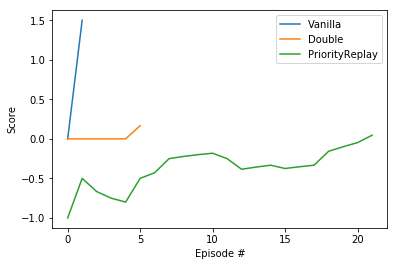

In [5]:
score_target = 0.01 # 13.0 to meet project goals
state_size = 37
action_size = 4
seed = 0
n_episodes=1000
max_t=1000
eps_start=0.5
eps_end=0.01
eps_decay=0.995

agent_dict = {
              "Vanilla":Vanilla(state_size, action_size, seed),
              "Double":Double(state_size, action_size, seed),
              "PriorityReplay":PriorityReplay(state_size, action_size, seed)
             }
results = train_unity(APP_PATH, CHART_PATH, timestamp, agent_dict, seed, 
                      score_target, n_episodes,max_t,eps_start,eps_end,eps_decay)

### Train Gym Lunar

### Resources

[Deep Q Network](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn).  Deep Reinforcement Learning Nanodegree, Udacity.

Albinet, Franck.  [Deep Q Network](https://github.com/franckalbinet/drlnd-project1/blob/master/dqn_agent.py).

